In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!cat '/content/drive/My Drive/MasterThesis/Datasets/Offensive2020/trainDev/NOT_OFF/1000.txt'

@USER @USER ان شاء الله يا غالي حبيبي يا محمد<LF>ودايما متجمعين علي عشق الكيان	NOT_OFF	NOT_HS


In [ ]:
batch_size = 32
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "/content/drive/My Drive/MasterThesis/Datasets/Offensive2020/trainDev",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
   
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "/content/drive/My Drive/MasterThesis/Datasets/Offensive2020/trainDev",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "/content/drive/My Drive/MasterThesis/Datasets/Offensive2020/test", batch_size=batch_size
)

print(
    "Number of batches in raw_train_ds: %d"
    % tf.data.experimental.cardinality(raw_train_ds)
)
print(
    "Number of batches in raw_val_ds: %d" % tf.data.experimental.cardinality(raw_val_ds)
)
print(
    "Number of batches in raw_test_ds: %d"
    % tf.data.experimental.cardinality(raw_test_ds)
)

Found 8000 files belonging to 2 classes.
Using 6400 files for training.
Found 8000 files belonging to 2 classes.
Using 1600 files for validation.
Found 2000 files belonging to 2 classes.
Number of batches in raw_train_ds: 200
Number of batches in raw_val_ds: 50
Number of batches in raw_test_ds: 63


In [ ]:
# It's important to take a look at your raw data to ensure your normalization
# and tokenization will work as expected. We can do that by taking a few
# examples from the training set and looking at them.
# This is one of the places where eager execution shines:
# we can just evaluate these tensors using .numpy()
# instead of needing to evaluate them in a Session/Graph context.
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(10):
        print(text_batch.numpy()[i].decode('utf-8').strip())
        print(label_batch.numpy()[i])
        print('--------------------------------')

RT @USER: يا رب يا عزيز يا جبار .. انك القادر على كل شيء .. يا رب فرحه اتحاديه تُنسينا كل الهموم والمشاكل الي صارت هالموسم يا رب العباد…	NOT_OFF	NOT_HS
0
--------------------------------
@USER @USER يا جامع يا رقيب يا رب تلقاها	NOT_OFF	NOT_HS
0
--------------------------------
راهنت عليك ولم اخسر ❤️❤️<LF>يا وحش يا جلاد يا كبير<LF>يا مرعب يا قناص يا يصياد<LF>🖤💛🖤💛🖤💛🖤💛<LF>#الاتحاد_النصر URL	NOT_OFF	NOT_HS
0
--------------------------------
RT @USER: كانت أيام يا وطني<LF>زي الأحلام يا وطني 🎶	NOT_OFF	NOT_HS
0
--------------------------------
تمثيل يا رزان تمثيل يا رزان تمثيل يا رزان تمثيل يا رزان تمثيل يا رزان تمثيل يا رزان	NOT_OFF	NOT_HS
0
--------------------------------
يا HBO يا شرموطة تنزلي الحلقة الأولى من GOT وانا معرفش يا لبوة .. أخص عليكي شركة إنتاج وثخة 😁😂	OFF	NOT_HS
1
--------------------------------
@USER يا سلام عليك يا عميد 💙💛 سلطان بطل وراح يبقى بطل مهما حصل حنا عيال النصر بكل الاحوال	NOT_OFF	NOT_HS
0
--------------------------------
@USER @USER يا دحابشه يا كرام ...<LF>الجنو

In [ ]:
# import re

# w1 = "مشكووووووووووووووووووووووووور"
# tf.strings.regex_replace(w1, "r'(.)\1+'", "r'\1'")
# re.sub(r'(.)\1+', r'\1', w1)

InvalidArgumentError: ignored

In [ ]:
import string
import re
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Having looked at our data above, we see that the raw text contains HTML break
# tags of the form '<br />'. These tags will not be removed by the default
# standardizer (which doesn't strip HTML). Because of this, we will need to
# create a custom standardization function.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    stripped_html = tf.strings.regex_replace(input_data, "[a-zA-Z]|\d+|[٠١٢٣٤٥٦٧٨٩]", " ")
    stripped_html = tf.strings.regex_replace(stripped_html, "[.،,\\_-”“٪ًَ]", " ")
    
    stripped_html = tf.strings.regex_replace(stripped_html, "[إأآا]", "ا")
    stripped_html = tf.strings.regex_replace(stripped_html, "ة", "ه")
    # stripped_html=tf.strings.regex_replace(stripped_html, "[(\U0001F600-\U0001F92F|\U0001F300-\U0001F5FF|\U0001F680-\U0001F6FF|\U0001F190-\U0001F1FF|\U00002702-\U000027B0|\U0001F926-\U0001FA9F|\u200d|\u2640-\u2642|\u2600-\u2B55|\u23cf|\u23e9|\u231a|\ufe0f)|\u2069|\u2066]+", " ")
    # after_remove_repeating_char = tf.strings.regex_replace(after_remove_emoji, "r'(.)\1+'", "r'\1\1'")




    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""

        
    )


# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

# Now that we have our custom standardization, we can instantiate our text
# vectorization layer. We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Now that the vocab layer has been created, call `adapt` on a text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.

# Let's make a text-only dataset (no labels):
text_ds = raw_train_ds.map(lambda x, y: x)
# Let's call `adapt`:
vectorize_layer.adapt(text_ds)

In [ ]:
vocab = np.array(vectorize_layer.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'يا', 'و', 'من', 'الله', 'في', 'ما', 'رب', 'لا', 'كل',
       'انت', 'انا', 'على', 'اللهم', 'ان', 'اللي', 'ولا', 'والله', 'عليك'],
      dtype='<U107')

# print the voc size for all texts, 

In [ ]:
encoded_example = vectorize_layer(text_batch)[:3].numpy()
encoded_example

array([[   2,    8,    2, ...,    0,    0,    0],
       [   2, 1641,    2, ...,    0,    0,    0],
       [   1,   19,  651, ...,    0,    0,    0]])

In [ ]:
for n in range(3):
  print("Original: ", text_batch[n].numpy().decode())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  RT @USER: يا رب يا عزيز يا جبار .. انك القادر على كل شيء .. يا رب فرحه اتحاديه تُنسينا كل الهموم والمشاكل الي صارت هالموسم يا رب العباد…	NOT_OFF	NOT_HS

Round-trip:  يا رب يا عزيز يا جبار انك القادر على كل شيء يا رب فرحه اتحاديه [UNK] كل الهموم والمشاكل الي صارت هالموسم يا رب [UNK]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

Original:  @USER @USER يا جامع يا رقيب يا رب تلقاها	NOT_OFF	NOT_HS

Round-trip:  يا جامع يا رقيب يا رب تلقاها                                                                                                                         

# Create the model

In [ ]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping

history = model.fit(raw_train_ds, epochs=30,
                    validation_data=raw_val_ds, 
                    validation_steps=30,
                    callbacks=[EarlyStopping(monitor='val_loss',patience=5)])
#add patience to earlystop

# history=model.fit(train_ds, validation_data=val_ds, epochs=epochs,
#           callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
200/200 [==============================] - 535s 3s/step - loss: 0.6310 - accuracy: 0.7888 - val_loss: 0.5052 - val_accuracy: 0.7948
Epoch 2/10
200/200 [==============================] - 15s 74ms/step - loss: 0.4859 - accuracy: 0.7927 - val_loss: 0.4376 - val_accuracy: 0.7937
Epoch 3/10
200/200 [==============================] - 15s 76ms/step - loss: 0.3735 - accuracy: 0.7924 - val_loss: 0.3599 - val_accuracy: 0.8135
Epoch 4/10
200/200 [==============================] - 15s 75ms/step - loss: 0.2144 - accuracy: 0.8840 - val_loss: 0.3396 - val_accuracy: 0.8646
Epoch 5/10
200/200 [==============================] - 15s 75ms/step - loss: 0.1052 - accuracy: 0.9609 - val_loss: 0.3686 - val_accuracy: 0.8729


In [ ]:
test_loss, test_acc = model.evaluate(raw_test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

63/63 [==============================] - 889s 12s/step - loss: 6.0294 - accuracy: 0.1260
Test Loss: 6.029353618621826
Test Accuracy: 0.12600000202655792


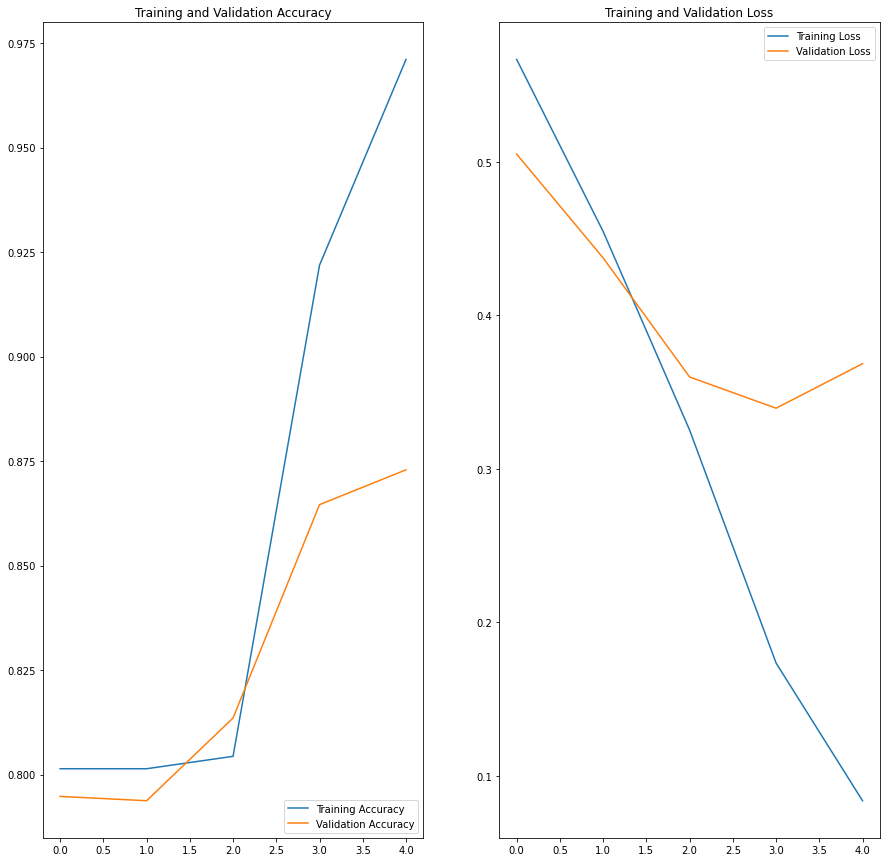

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

#epochs_range = range(22)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sample_text = (' يا حبيبي بكل صفاتہ يا دموع و يا خضوع  ')
predictions = model.predict(np.array([sample_text]))
predictions
#NOT hate speech

array([[-6.1433263]], dtype=float32)

In [ ]:
sample_text = (' القم يا ايطالي يا ابن الكلب انت و باصك يلعن اهلك  ')
predictions = model.predict(np.array([sample_text]))
predictions
#Hate

array([[4.524784]], dtype=float32)